In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

seed = 123
rng = np.random.default_rng(seed)

%matplotlib inline
%config InlineBackend.figure_format='retina'

\begin{gather}
    \left\{
    \begin{aligned}
        & x_1(k+1) = \theta_1 x_1(k) + x_1(k) x_2(k) + 0.1 + \alpha v_1(k),\\
        & x_2(k+1) = \theta_2 x_2(k) - x_1(k) x_2(k) + 0.1 + \alpha v_2(k),\\
        & y_1(k) = x_2(k) + \alpha w(k).
    \end{aligned}
    \right.
\end{gather}

\begin{gather}
    X(k) = (x_1(k), x_2(k), \theta_1, \theta_2)^\top
\end{gather}


\begin{gather}
    a(x_1, x_2, \theta_1, \theta_2) =
        \begin{pmatrix}
            \theta_1 x_1 + x_1 x_2 + 0.1\\
            \theta_2 x_2 - x_1 x_2 + 0.1\\
            \theta_1\\
            \theta_2
        \end{pmatrix}
\end{gather}

\begin{gather}
    \nabla a(x_1, x_2, \theta_1, \theta_2) = 
        \begin{pmatrix}
            \theta_1 + x_2 & x_1 & x_1 & 0 \\
            -x_2 &\theta_2 - x_1 & 0 & x_2 \\
            0 & 0 & 1 & 0 \\
            0 & 0 & 0 & 1 
        \end{pmatrix}
\end{gather}

\begin{gather}
    \nabla^2 a^1(x_1, x_2, \theta_1, \theta_2) = 
        \begin{pmatrix}
            0 &  1 & 1 & 0 \\
            1 &  0 & 0 & 0 \\
            1 &  0 & 0 & 0 \\
            0 &  0 & 0 & 0 
        \end{pmatrix}, \quad
    \nabla^2 a^2(x_1, x_2, \theta_1, \theta_2) = 
        \begin{pmatrix}
             0 & -1 & 0 & 0\\
            -1 &  0 & 0 & 1\\
             0 &  0 & 0 & 0 \\
             0 &  1 & 0 & 0 
        \end{pmatrix}, \quad
    \nabla^2 a^3(x_1, x_2, \theta_1, \theta_2) = \nabla^2 a^4(x_1, x_2, \theta_1, \theta_2) =
        \begin{pmatrix}
             0 & 0 & 0 & 0 \\
             0 & 0 & 0 & 0 \\
             0 & 0 & 0 & 0 \\
             0 & 0 & 0 & 0 
        \end{pmatrix}.
\end{gather}

In [2]:
theta1 = 0.8
theta2 = 1.5
x01 = 1.35
x02 = 0.11
x0 = np.array([x01, x02, theta1, theta2])

alpha = 0.01


def a(x):
    res = x.copy()
    res[0] = (x[1] + x[2]) * x[0] + 0.1
    res[1] = (x[3] - x[0]) * x[1] + 0.1
    return res


def grad_a(x):
    res = np.zeros((4, 4))
    # x1
    res[0, 0] = x[2] + x[1]
    res[0, 1] = x[0]
    res[0, 2] = x[0]
    res[0, 3] = 0
    # x2
    res[1, 0] = -x[1]
    res[1, 1] = x[3] - x[0]
    res[1, 2] = 0
    res[1, 3] = x[1]
    # x3
    res[2, 0] = 0
    res[2, 1] = 0
    res[2, 2] = 1
    res[2, 3] = 0
    # x4
    res[3, 0] = 0
    res[3, 1] = 0
    res[3, 2] = 0
    res[3, 3] = 1
    return res


Hessian = np.zeros((4, 4, 4))

Hessian[0, 0, 1] = 1
Hessian[0, 0, 2] = 1
Hessian[0, 1, 0] = 1
Hessian[0, 2, 0] = 1

Hessian[1, 0, 1] = -1
Hessian[1, 1, 3] = 1
Hessian[1, 1, 0] = -1
Hessian[1, 3, 1] = 1


def H_a(x):
    return Hessian.copy()


def A(x):
    return np.array([x[1]])


gr_A = np.zeros((1, 4))
gr_A[0, 1] = 1


def grad_A(x):
    return gr_A.copy()


def H_A(x):
    return np.zeros((1, 4, 4))


sys_noise_points = [alpha * np.array([-1, 0, 3]), alpha * np.array([-1, 4])]
sys_noise_probs = [np.array([0.6, 0.2, 0.2]), np.array([0.8, 0.2])]
obs_noise_points = [alpha * np.array([-7, 3])]
obs_noise_probs = [np.array([0.3, 0.7])]


class System(object):
    def __init__(
        self,
        x0,
        a,
        A,
        alpha,
        N_paths=100,
        rng=rng,
        sys_noise_points=sys_noise_points,
        sys_noise_probs=sys_noise_probs,
        obs_noise_points=obs_noise_points,
        obs_noise_probs=obs_noise_probs,
    ):
        self.x = x0[:, np.newaxis].repeat(N_paths, axis=-1)

        self.a = a
        self.A = A
        self.alpha = alpha
        self.rng = rng
        self.N_paths = N_paths
        self.sys_noise_points = sys_noise_points
        self.sys_noise_probs = sys_noise_probs
        self.obs_noise_points = obs_noise_points
        self.obs_noise_probs = obs_noise_probs

    def step(self):
        self.x = self.a(self.x)
        for i in range(2):
            self.x[1] += self.rng.choice(
                self.sys_noise_points[i], p=self.sys_noise_probs[i], size=self.N_paths
            )
        return self.x

    def get_obs(self):
        res = self.A(self.x)
        for i in range(1):
            res[i] += self.rng.choice(
                self.obs_noise_points[i], p=self.obs_noise_probs[i], size=self.N_paths
            )
        return res


def tria(a):
    R = sp.linalg.qr(a.T, mode="r")[0]
    for i in range(R.shape[1]):
        if R[i, i] < 0:
            R[:, i] *= -1
    return R[: R.shape[1], :].T

In [3]:
sys = System(x0, a, A, alpha)

In [ ]:
state = [x0[:, np.newaxis].repeat(sys.N_paths, axis=-1)]
obs = []

obs_freq = 1

hidden_steps = 0

T = 800

for t in range(1, T):
    for _ in range(hidden_steps):
        sys.step()
    state.append(sys.step())
    if t % obs_freq == 0:
        obs.append(sys.get_obs())

state = np.array(state)
obs = np.array(obs)

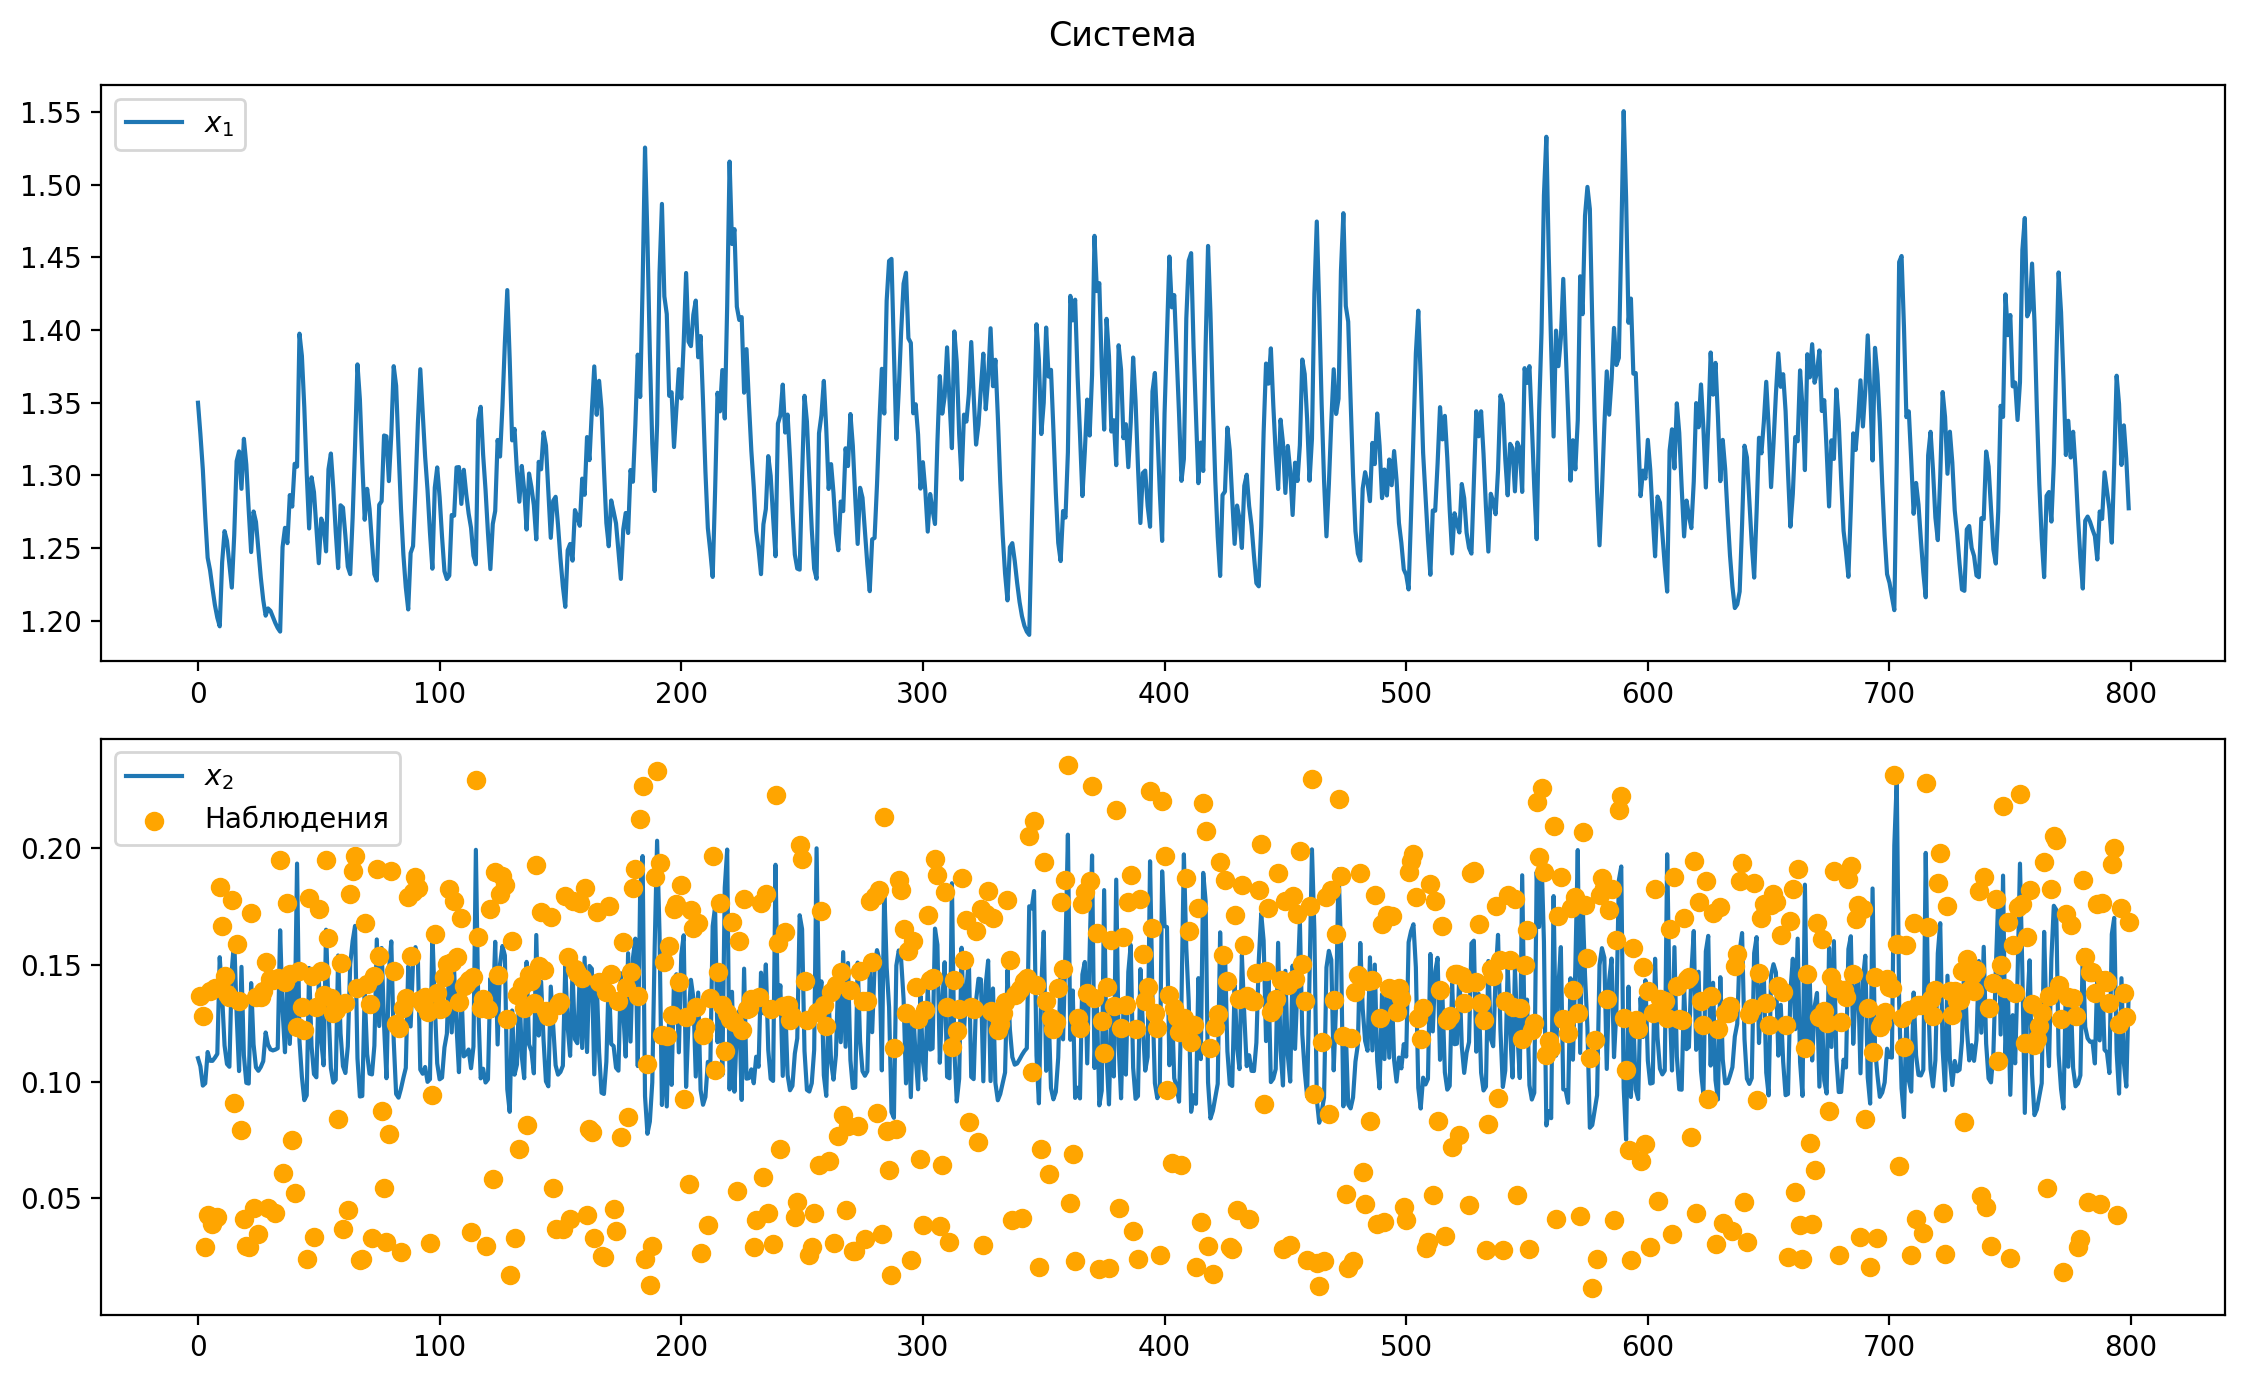

In [5]:
fig, ax = plt.subplots(2, figsize=(7 * (1 + np.sqrt(5)) / 2, 7), layout="tight")

for i in range(2):
    ax[i].plot(np.arange(T), state[:, i, 0], label=f"$x_{i+1}$")
ax[1].scatter(
    np.arange(obs_freq, T, step=obs_freq),
    obs[:, 0, 0],
    color="orange",
    zorder=2,
    label="Наблюдения",
)

ax[0].legend(loc="upper left")


ax[1].legend(loc="upper left")

fig.suptitle("Система")

plt.show()

# EKF 2

In [6]:
class ExtendedKF2(object):
    def __init__(
        self, a, grad_a, H_a, A, grad_A, H_A, x_init, cov_init, cov_sys, cov_obs
    ):
        self.a = a
        self.grad_a = grad_a
        self.H_a = H_a
        self.A = A
        self.grad_A = grad_A
        self.H_A = H_A
        self.cov_init = cov_init
        self.cov_sys = cov_sys
        self.cov_obs = cov_obs
        self.x = x_init
        self.k = cov_init

    def predict(self):
        gr_a = self.grad_a(self.x)
        Hess_a = self.H_a(self.x)

        shift_x = np.empty(self.x.shape)
        shift_k = np.empty(self.k.shape)
        for i in range(Hess_a.shape[0]):
            shift_x[i] = 0.5 * np.trace(Hess_a[i] @ self.k)
            for j in range(i + 1):
                shift_k[i, j] = 0.5 * np.trace(Hess_a[i] @ self.k @ Hess_a[j] @ self.k)
                if i != j:
                    shift_k[j, i] = shift_k[i, j]

        self.x = self.a(self.x) + shift_x
        self.k = gr_a @ self.k @ gr_a.T + shift_k + self.cov_sys

        return self.x, self.k

    def update(self, Y):
        gr_A = self.grad_A(self.x)
        Hess_A = self.H_A(self.x)

        Y_pred = self.A(self.x)

        mu = self.k @ gr_A.T
        q = gr_A @ mu + self.cov_obs
        for i in range(Hess_A.shape[0]):
            Y_pred[i] += 0.5 * np.trace(Hess_A[i] @ self.k)
            for j in range(i + 1):
                q[i, j] += 0.5 * np.trace(Hess_A[i] @ self.k @ Hess_A[j] @ self.k)
                if i != j:
                    q[j, i] = q[i, j]
        Kalman_gain = mu @ np.linalg.inv(q)
        self.x += Kalman_gain @ (Y - Y_pred)
        self.k -= Kalman_gain @ mu.T
        return self.x, self.k


class SR_ExtendedKF2(ExtendedKF2):
    def __init__(
        self,
        a,
        grad_a,
        H_a,
        A,
        grad_A,
        H_A,
        x_init,
        cov_init_sqrt,
        cov_sys_sqrt,
        cov_obs_sqrt,
    ):
        super().__init__(
            a=a,
            grad_a=grad_a,
            H_a=H_a,
            A=A,
            grad_A=grad_A,
            H_A=H_A,
            x_init=x_init,
            cov_init=cov_init_sqrt @ cov_init_sqrt.T,
            cov_sys=cov_sys_sqrt @ cov_sys_sqrt.T,
            cov_obs=cov_obs_sqrt @ cov_obs_sqrt.T,
        )
        self.cov_sys_sqrt = cov_sys_sqrt
        self.cov_obs_sqrt = cov_obs_sqrt
        self.s = cov_init_sqrt

    def predict(self):
        gr_a = self.grad_a(self.x)
        Hess_a = self.H_a(self.x)

        shift_x = np.empty(self.x.shape)
        shift_k = np.empty(self.s.shape)
        for i in range(Hess_a.shape[0]):
            shift_x[i] = 0.5 * np.trace(self.s @ Hess_a[i] @ self.s.T)
            for j in range(i + 1):
                shift_k[i, j] = 0.5 * np.trace(
                    Hess_a[i] @ self.s @ self.s.T @ Hess_a[j] @ self.s @ self.s.T
                )
                if i != j:
                    shift_k[j, i] = shift_k[i, j]

        self.x = self.a(self.x) + shift_x
        self.s = tria(np.hstack([gr_a @ self.s.T, tria(shift_k + self.cov_sys)]))

        return self.x, self.s

    def update(self, Y):
        gr_A = self.grad_A(self.x)
        Hess_A = self.H_A(self.x)

        Y_pred = self.A(self.x)
        ky_shift = np.zeros((Y_pred.shape[0], Y_pred.shape[0]))

        for i in range(Hess_A.shape[0]):
            Y_pred[i] += 0.5 * np.trace(Hess_A[i] @ self.s @ self.s.T)
            for j in range(i + 1):
                ky_shift[i, j] = 0.5 * np.trace(
                    self.s @ Hess_A[i] @ self.s.T @ self.s @ Hess_A[j] @ self.s.T
                )
                if i != j:
                    ky_shift[j, i] = ky_shift[i, j]

        D = tria(
            np.block(
                [
                    [
                        tria(self.cov_obs + ky_shift),
                        np.zeros((self.cov_obs.shape[0], self.s.shape[1])),
                    ],
                    [self.s @ gr_A.T, self.s],
                ]
            )
        )

        V = D[: Y.shape[0], : Y.shape[0]]
        L = D[Y.shape[0] :, : Y.shape[0]]

        Kalman_gain = L @ np.linalg.inv(V)
        self.x += Kalman_gain @ (Y - Y_pred)
        self.s = D[Y.shape[0] :, Y.shape[0] :]
        return self.x, self.s

In [7]:
class noise_generator(object):
    # чтоб странные шумы делать
    def __init__(self, sys_noise_points, sys_noise_probs, sigma1, sigma2, rng=rng):
        self.rng = rng
        self.sys_noise_points = sys_noise_points
        self.sys_noise_probs = sys_noise_probs
        self.sigma1 = sigma1
        self.sigma2 = sigma2

    def get(self, N):
        return np.vstack(
            [
                self.rng.choice(
                    self.sys_noise_points[0], p=self.sys_noise_probs[0], size=N
                ),
                self.rng.choice(
                    self.sys_noise_points[1], p=self.sys_noise_probs[1], size=N
                ),
                self.rng.normal(0, self.sigma1, size=N),
                self.rng.normal(0, self.sigma2, size=N),
            ]
        )


class BootstrapF(object):
    def __init__(
        self,
        N_samples,
        cond_density,
        x_init,
        a,
        A,
        noise_generator,
        x_init_func,
        rng=rng,
    ):
        self.rng = rng
        self.a = a
        self.A = A
        self.density = cond_density
        self.noise = noise_generator
        self.N_samples = N_samples
        self.X = x_init_func(N_samples, rng=rng)
        self.w = np.repeat(1 / N_samples, N_samples)

    def resample(self):
        self.X = self.X[
            :,
            self.rng.choice(
                np.arange(self.N_samples, dtype=np.int64), p=self.w, size=self.N_samples
            ),
        ]
        self.w = np.repeat(1 / self.N_samples, self.N_samples)

    def predict(self, need_std=False):
        self.X = self.a(self.X) + self.noise.get(self.N_samples)
        if need_std:
            m = self.X @ self.w
            centered_Xs = self.X - m[:, np.newaxis]
            return m, np.sqrt(centered_Xs**2 @ self.w)
        else:
            return self.X @ self.w

    def update(self, Y, need_std=False):
        self.w *= self.density(Y, self.X)
        self.w /= self.w.sum()
        if need_std:
            m = self.X @ self.w
            centered_Xs = self.X - m[:, np.newaxis]
            return m, np.sqrt(centered_Xs**2 @ self.w)
        else:
            return self.X @ self.w

In [ ]:
rng2 = np.random.default_rng(seed=52)

gen = noise_generator(
    sys_noise_points=sys_noise_points,
    sys_noise_probs=sys_noise_probs,
    sigma1=1e-2,
    sigma2=1e-2,
    rng=rng2,
)

std_init_for_PF = np.array([1e-2, 1e-2, 1, 1])


def norm(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)


def cond_density(Y, X, A=A):
    tmp = A(X)
    return obs_noise_probs[0][0] * norm(
        tmp[0], Y[0] - obs_noise_points[0][0], 1e-2
    ) + obs_noise_probs[0][1] * norm(tmp[0], Y[0] - obs_noise_points[0][1], 1e-2)

In [9]:
x_init = np.array([x01, x02, 0.6, 1.3])


def init_func(N, x_init=x_init, sigma=std_init_for_PF, rng=rng2):
    res = x_init[:, np.newaxis].repeat(N, axis=-1)
    res += std_init_for_PF[:, np.newaxis] * rng.normal(0, 1, size=(4, N))
    return res


cov_init = np.diag([0, 0, 1e-2, 1e-2])
cov_sys = np.diag([alpha**2 * 2.4, alpha**2 * 4, 1e-6, 1e-6])
cov_obs = np.diag([alpha**2 * 21])

EKF2 = ExtendedKF2(
    a=a,
    grad_a=grad_a,
    H_a=H_a,
    A=A,
    grad_A=grad_A,
    H_A=H_A,
    x_init=x_init,
    cov_init=cov_init,
    cov_sys=cov_sys,
    cov_obs=cov_obs,
)

cov_init_2_sqrt = np.sqrt(np.diag([0, 0, 1e-2, 1e-2]))
cov_sys_2_sqrt = np.sqrt([alpha * np.sqrt(2.4), alpha * 2, 1e-6, 1e-6])
cov_obs_2_sqrt = np.sqrt(cov_obs)

SREKF2 = SR_ExtendedKF2(
    a=a,
    grad_a=grad_a,
    H_a=H_a,
    A=A,
    grad_A=grad_A,
    H_A=H_A,
    x_init=x_init,
    cov_init_sqrt=cov_init_2_sqrt,
    cov_sys_sqrt=cov_sys_2_sqrt,
    cov_obs_sqrt=cov_obs_2_sqrt,
)

N_samples = 100000
n_eff_tres = N_samples / 10

PFboot = BootstrapF(
    N_samples=N_samples,
    cond_density=cond_density,
    x_init=x_init,
    a=a,
    A=A,
    noise_generator=gen,
    x_init_func=init_func,
    rng=rng2,
)

PF_est = [x_init]
PF_std = [std_init_for_PF]
EKF_est = [x_init]
EKF_std = [np.sqrt(np.diagonal(cov_init))]
SREKF_est = [x_init]
SREKF_std = [np.diagonal(cov_init_2_sqrt)]

resample_counter = 0

path_idx = 0

for t in range(1, T):
    x1, k1 = EKF2.predict()
    x2, s2 = SREKF2.predict()
    x3, s3 = PFboot.predict(need_std=True)
    obs_t = t // obs_freq
    if (t % obs_freq == 0) and (obs_t < obs.shape[0]):
        x1, k1 = EKF2.update(obs[obs_t, :, path_idx])
        x2, s2 = SREKF2.update(obs[obs_t, :, path_idx])
        x3, s3 = PFboot.update(obs[t // obs_freq, :, path_idx], need_std=True)

    if 1 / (PFboot.w**2).sum() < n_eff_tres:
        PFboot.resample()
        resample_counter += 1
        # print(f't={t}: resample!')

    PFboot.noise.sigma1 *= 0.7
    PFboot.noise.sigma2 *= 0.7

    EKF_est.append(x1)
    EKF_std.append(np.sqrt(np.diagonal(k1)))
    SREKF_est.append(x2)
    SREKF_std.append(np.diagonal(s2))
    PF_est.append(x3)
    PF_std.append(s3)

/tmp/ipykernel_64826/2482091854.py:95: RuntimeWarning: overflow encountered in matmul
  Hess_a[i] @ self.s @ self.s.T @ Hess_a[j] @ self.s @ self.s.T
/tmp/ipykernel_64826/2482091854.py:95: RuntimeWarning: invalid value encountered in matmul
  Hess_a[i] @ self.s @ self.s.T @ Hess_a[j] @ self.s @ self.s.T
/tmp/ipykernel_64826/2532149256.py:12: RuntimeWarning: overflow encountered in scalar multiply
  res[0] = (x[1] + x[2]) * x[0] + 0.1
/tmp/ipykernel_64826/2532149256.py:13: RuntimeWarning: overflow encountered in scalar multiply
  res[1] = (x[3] - x[0]) * x[1] + 0.1
/tmp/ipykernel_64826/2482091854.py:101: RuntimeWarning: overflow encountered in matmul
  self.s = tria(np.hstack([gr_a @ self.s.T, tria(shift_k + self.cov_sys)]))


ValueError: array must not contain infs or NaNs

In [ ]:
EKF_est = np.array(EKF_est)
EKF_std = np.array(EKF_std)
SREKF_est = np.array(SREKF_est)
SREKF_std = np.array(SREKF_std)
PF_est = np.array(PF_est)
PF_std = np.array(PF_std)

if np.any(np.abs(EKF_est[100:] - state[100:, :, path_idx]) > 5 * EKF_std[100:]):
    print("EKF   diverged!")
if np.any(np.abs(SREKF_est[100:] - state[100:, :, path_idx]) > 5 * SREKF_std[100:]):
    print("SREKF diverged!")
if np.any(np.abs(PF_est[100:] - state[100:, :, path_idx]) > 5 * PF_std[100:]):
    print("PF    diverged!")

PF    diverged!


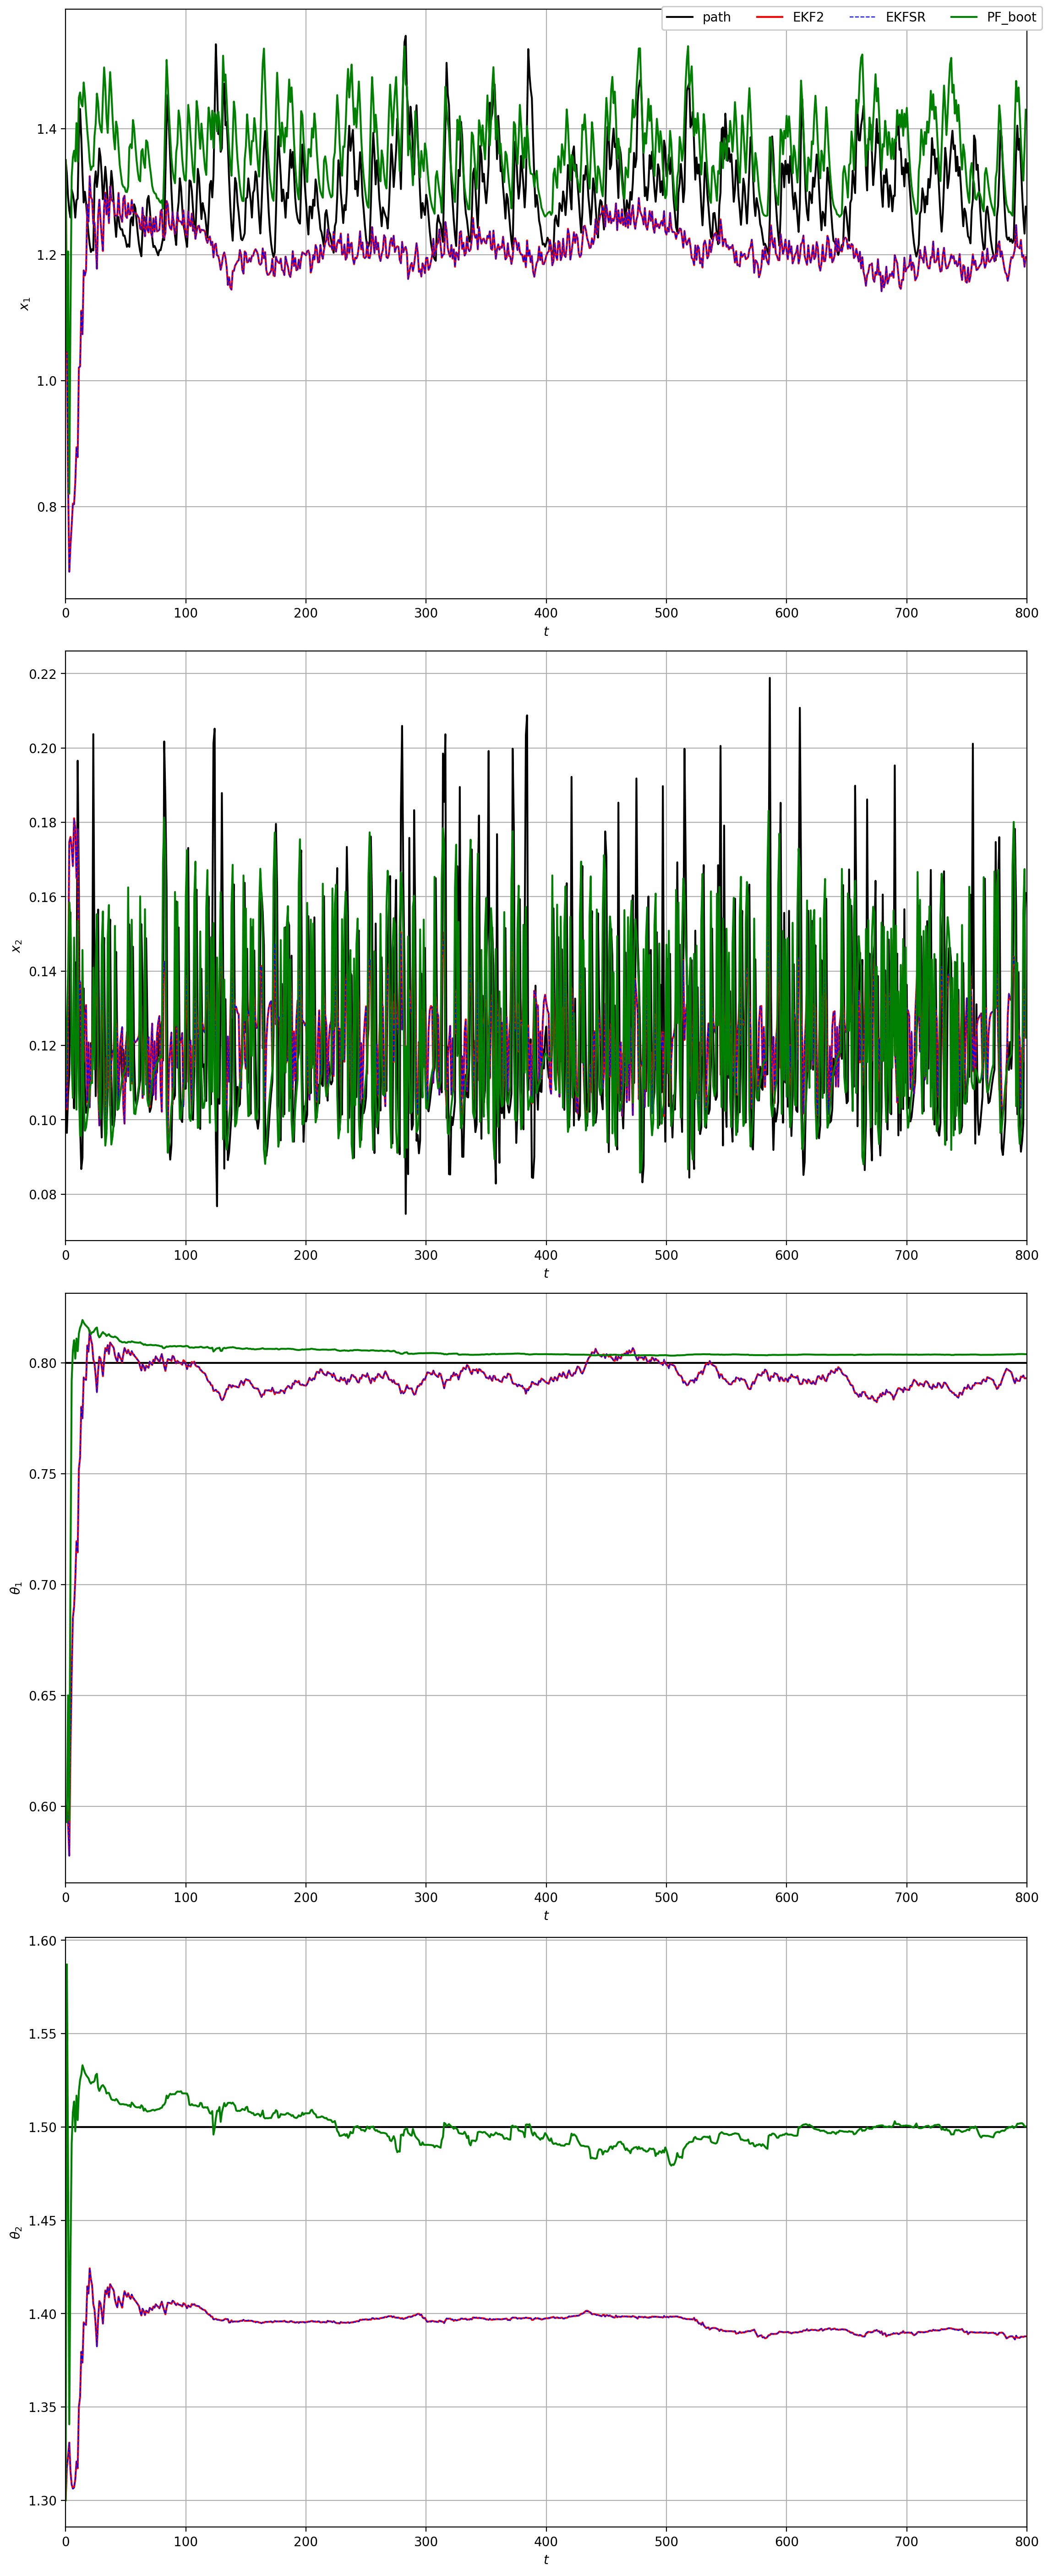

In [ ]:
fig, axs = plt.subplots(
    4, figsize=(7 * (1 + np.sqrt(5)) / 2, 7 * 4), layout="constrained"
)

names = ["$x_1$", "$x_2$", "$\\theta_1$", "$\\theta_2$"]

for i in range(4):
    (line1,) = axs[i].plot(
        np.arange(T), state[:, i, path_idx], label="path", lw=1.5, color="k"
    )
    (line2,) = axs[i].plot(
        np.arange(T), EKF_est[:, i], label="EKF2", color="red", lw=1.5
    )
    (line3,) = axs[i].plot(
        np.arange(T), SREKF_est[:, i], label="EKFSR", color="blue", lw=0.8, ls="--"
    )

    # line3, = ax[i].plot(np.arange(T), SREKF_est[:, i], label='SREKF', color='orange', )
    (line4,) = axs[i].plot(
        np.arange(T),
        PF_est[:, i],
        label="PF_boot",
        color="green",
    )
    axs[i].set_xlabel("$t$")
    axs[i].set_ylabel(names[i])
    axs[i].set_xlim(0, T)
    axs[i].grid()

    fig.legend(handles=[line1, line2, line3, line4], ncols=4, framealpha=1)

plt.show()

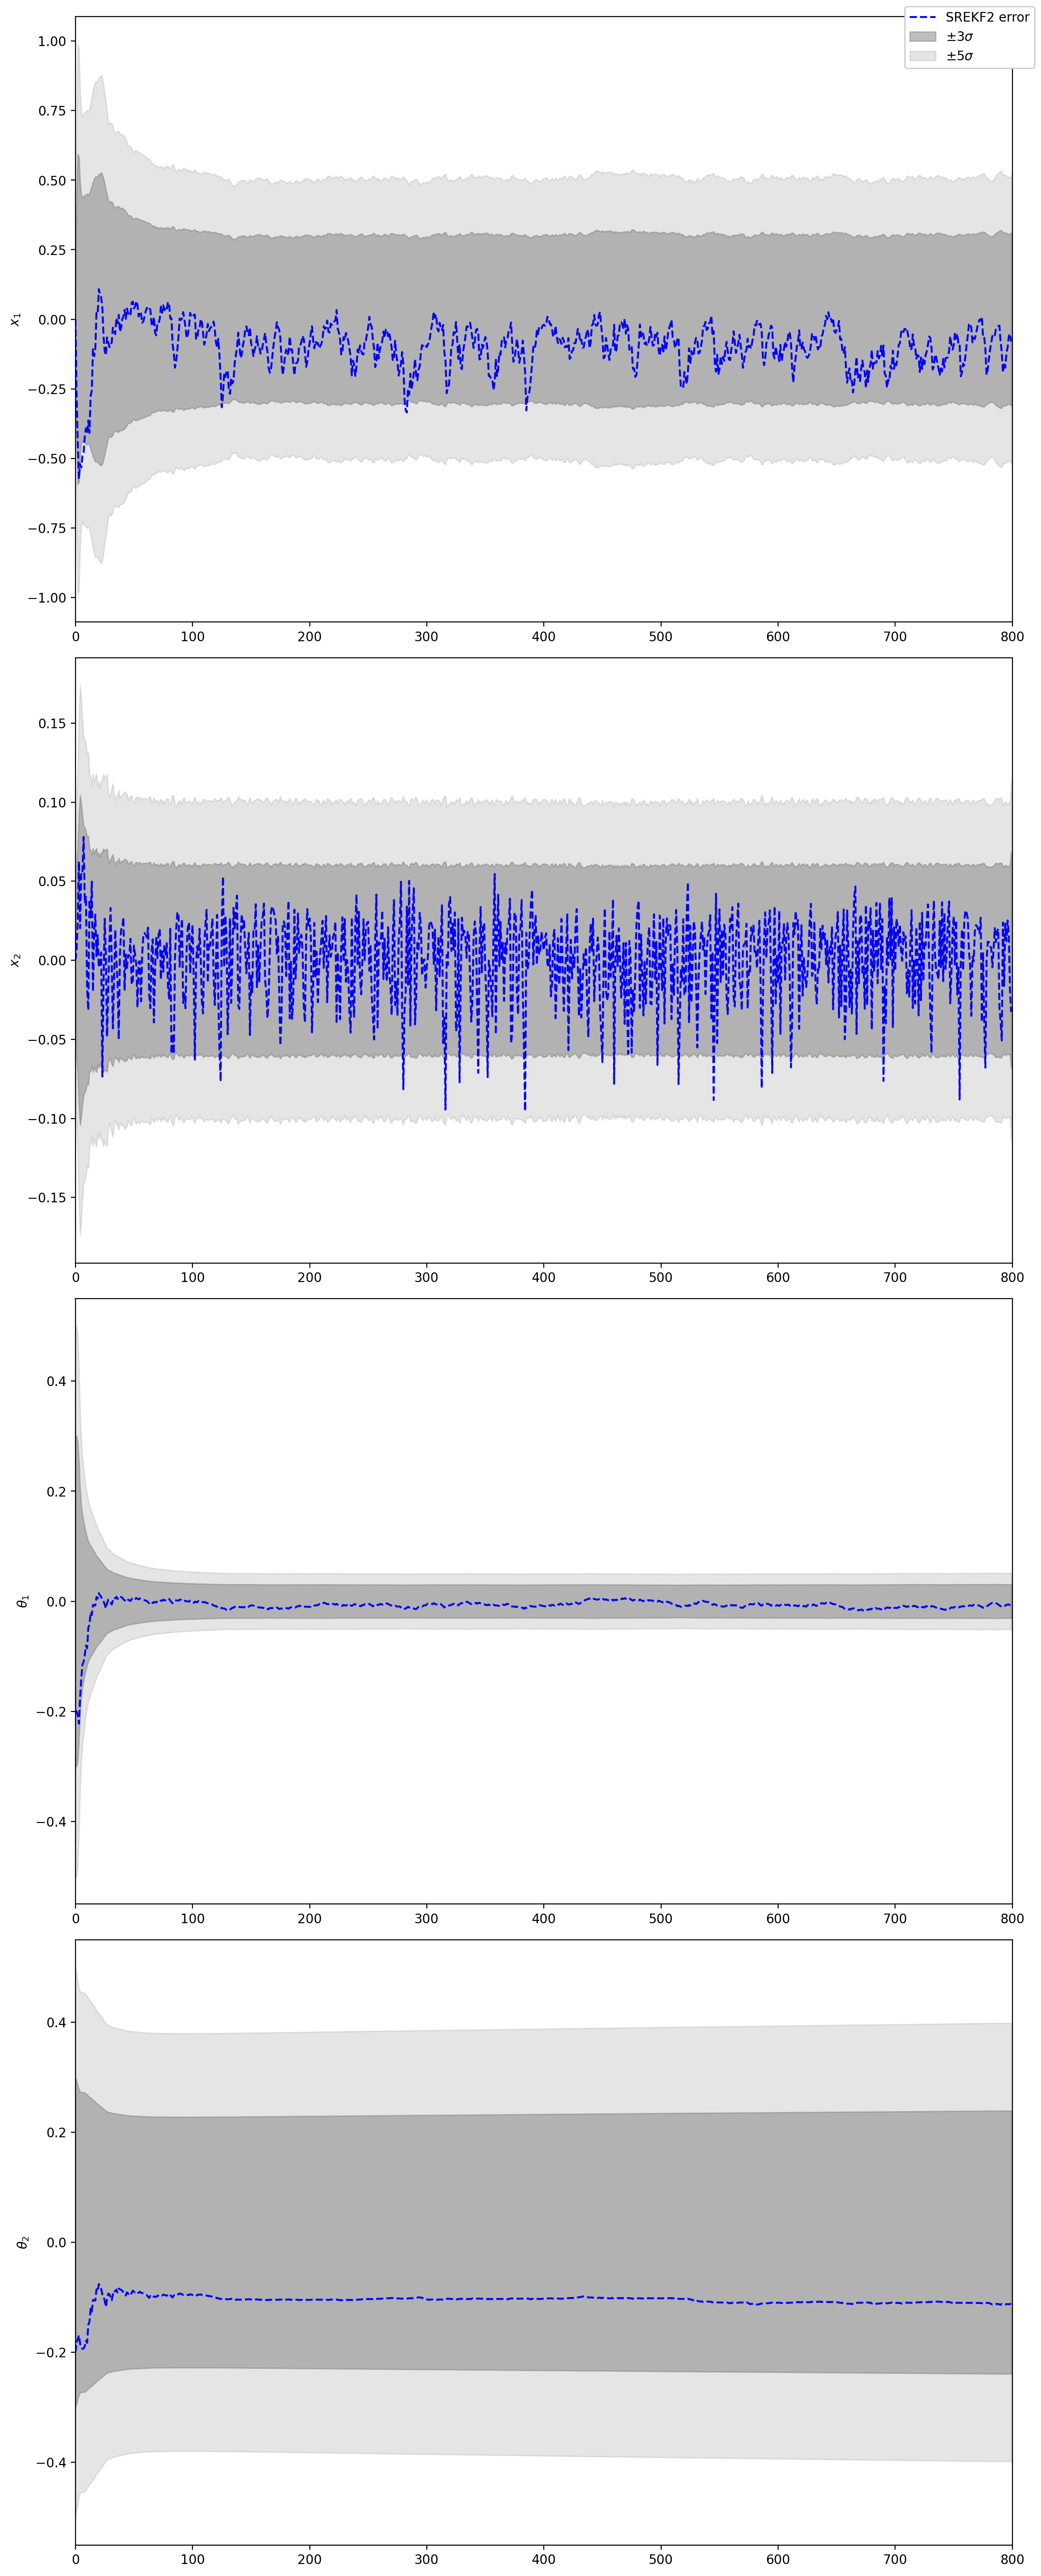

In [ ]:
fig, axs = plt.subplots(4, figsize=(7 * (1 + np.sqrt(5)) / 2, 7 * 4), layout="tight")

for i in range(4):
    err1 = EKF_est[:, i] - state[:, i, path_idx]
    (line1,) = axs[i].plot(
        np.arange(T), err1, color="blue", ls="--", label="SREKF2 error"
    )
    line2 = axs[i].fill_between(
        np.arange(T),
        -3 * EKF_std[:, i],
        3 * EKF_std[:, i],
        color="gray",
        alpha=0.5,
        label="$\\pm 3\\sigma$",
    )
    line3 = axs[i].fill_between(
        np.arange(T),
        -5 * EKF_std[:, i],
        5 * EKF_std[:, i],
        color="gray",
        alpha=0.2,
        label="$\\pm 5\\sigma$",
    )
    axs[i].set_ylabel(names[i])
    axs[i].set_xlim(0, T)

fig.legend(handles=[line1, line2, line3], framealpha=1)

plt.show()

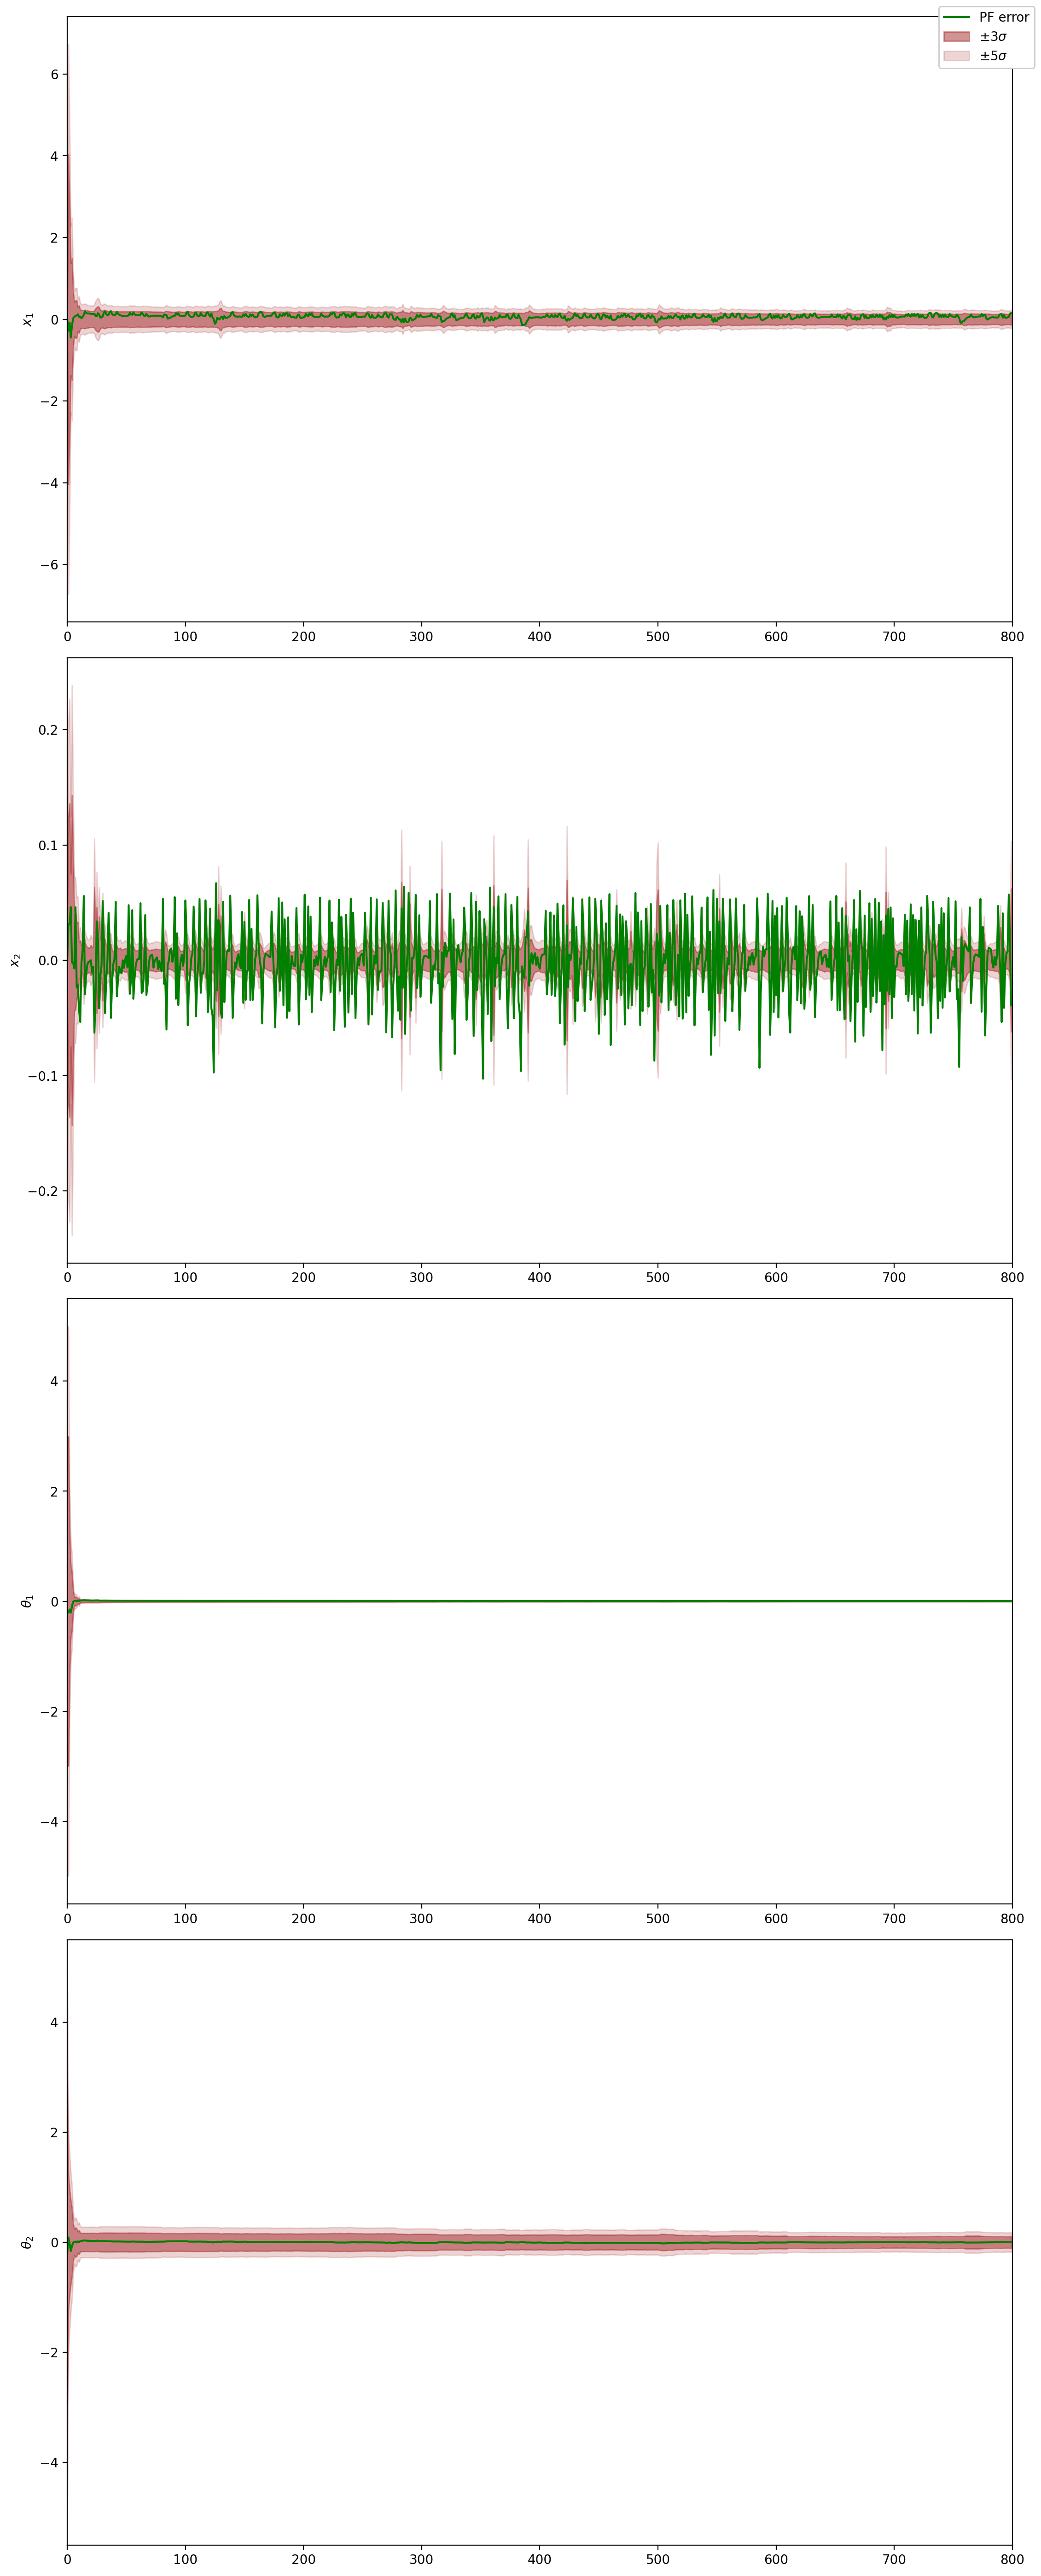

In [14]:
fig, axs = plt.subplots(4, figsize=(7 * (1 + np.sqrt(5)) / 2, 7 * 4), layout="tight")

for i in range(4):
    err1 = PF_est[:, i] - state[:, i, path_idx]
    (line1,) = axs[i].plot(np.arange(T), err1, color="green", label="PF error")
    line2 = axs[i].fill_between(
        np.arange(T),
        -3 * PF_std[:, i],
        3 * PF_std[:, i],
        color="brown",
        alpha=0.5,
        label="$\\pm 3 \\sigma$",
    )
    line3 = axs[i].fill_between(
        np.arange(T),
        -5 * PF_std[:, i],
        5 * PF_std[:, i],
        color="brown",
        alpha=0.2,
        label="$\\pm 5 \\sigma$",
    )
    axs[i].set_ylabel(names[i])
    axs[i].set_xlim(0, T)

fig.legend(handles=[line1, line2, line3], framealpha=1)

plt.show()

In [ ]:
mse_ekf2 = np.loadtxt("ekf2.csv", delimiter=",")
mse_srekf2 = np.loadtxt("srekf2.csv", delimiter=",")
mse_pf = np.loadtxt("pf.csv", delimiter=",")

0.02845 & 0.03416 & 0.04164
0.00417 & 0.00411 & 0.00419
0.00418 & 0.00412 & 0.0042


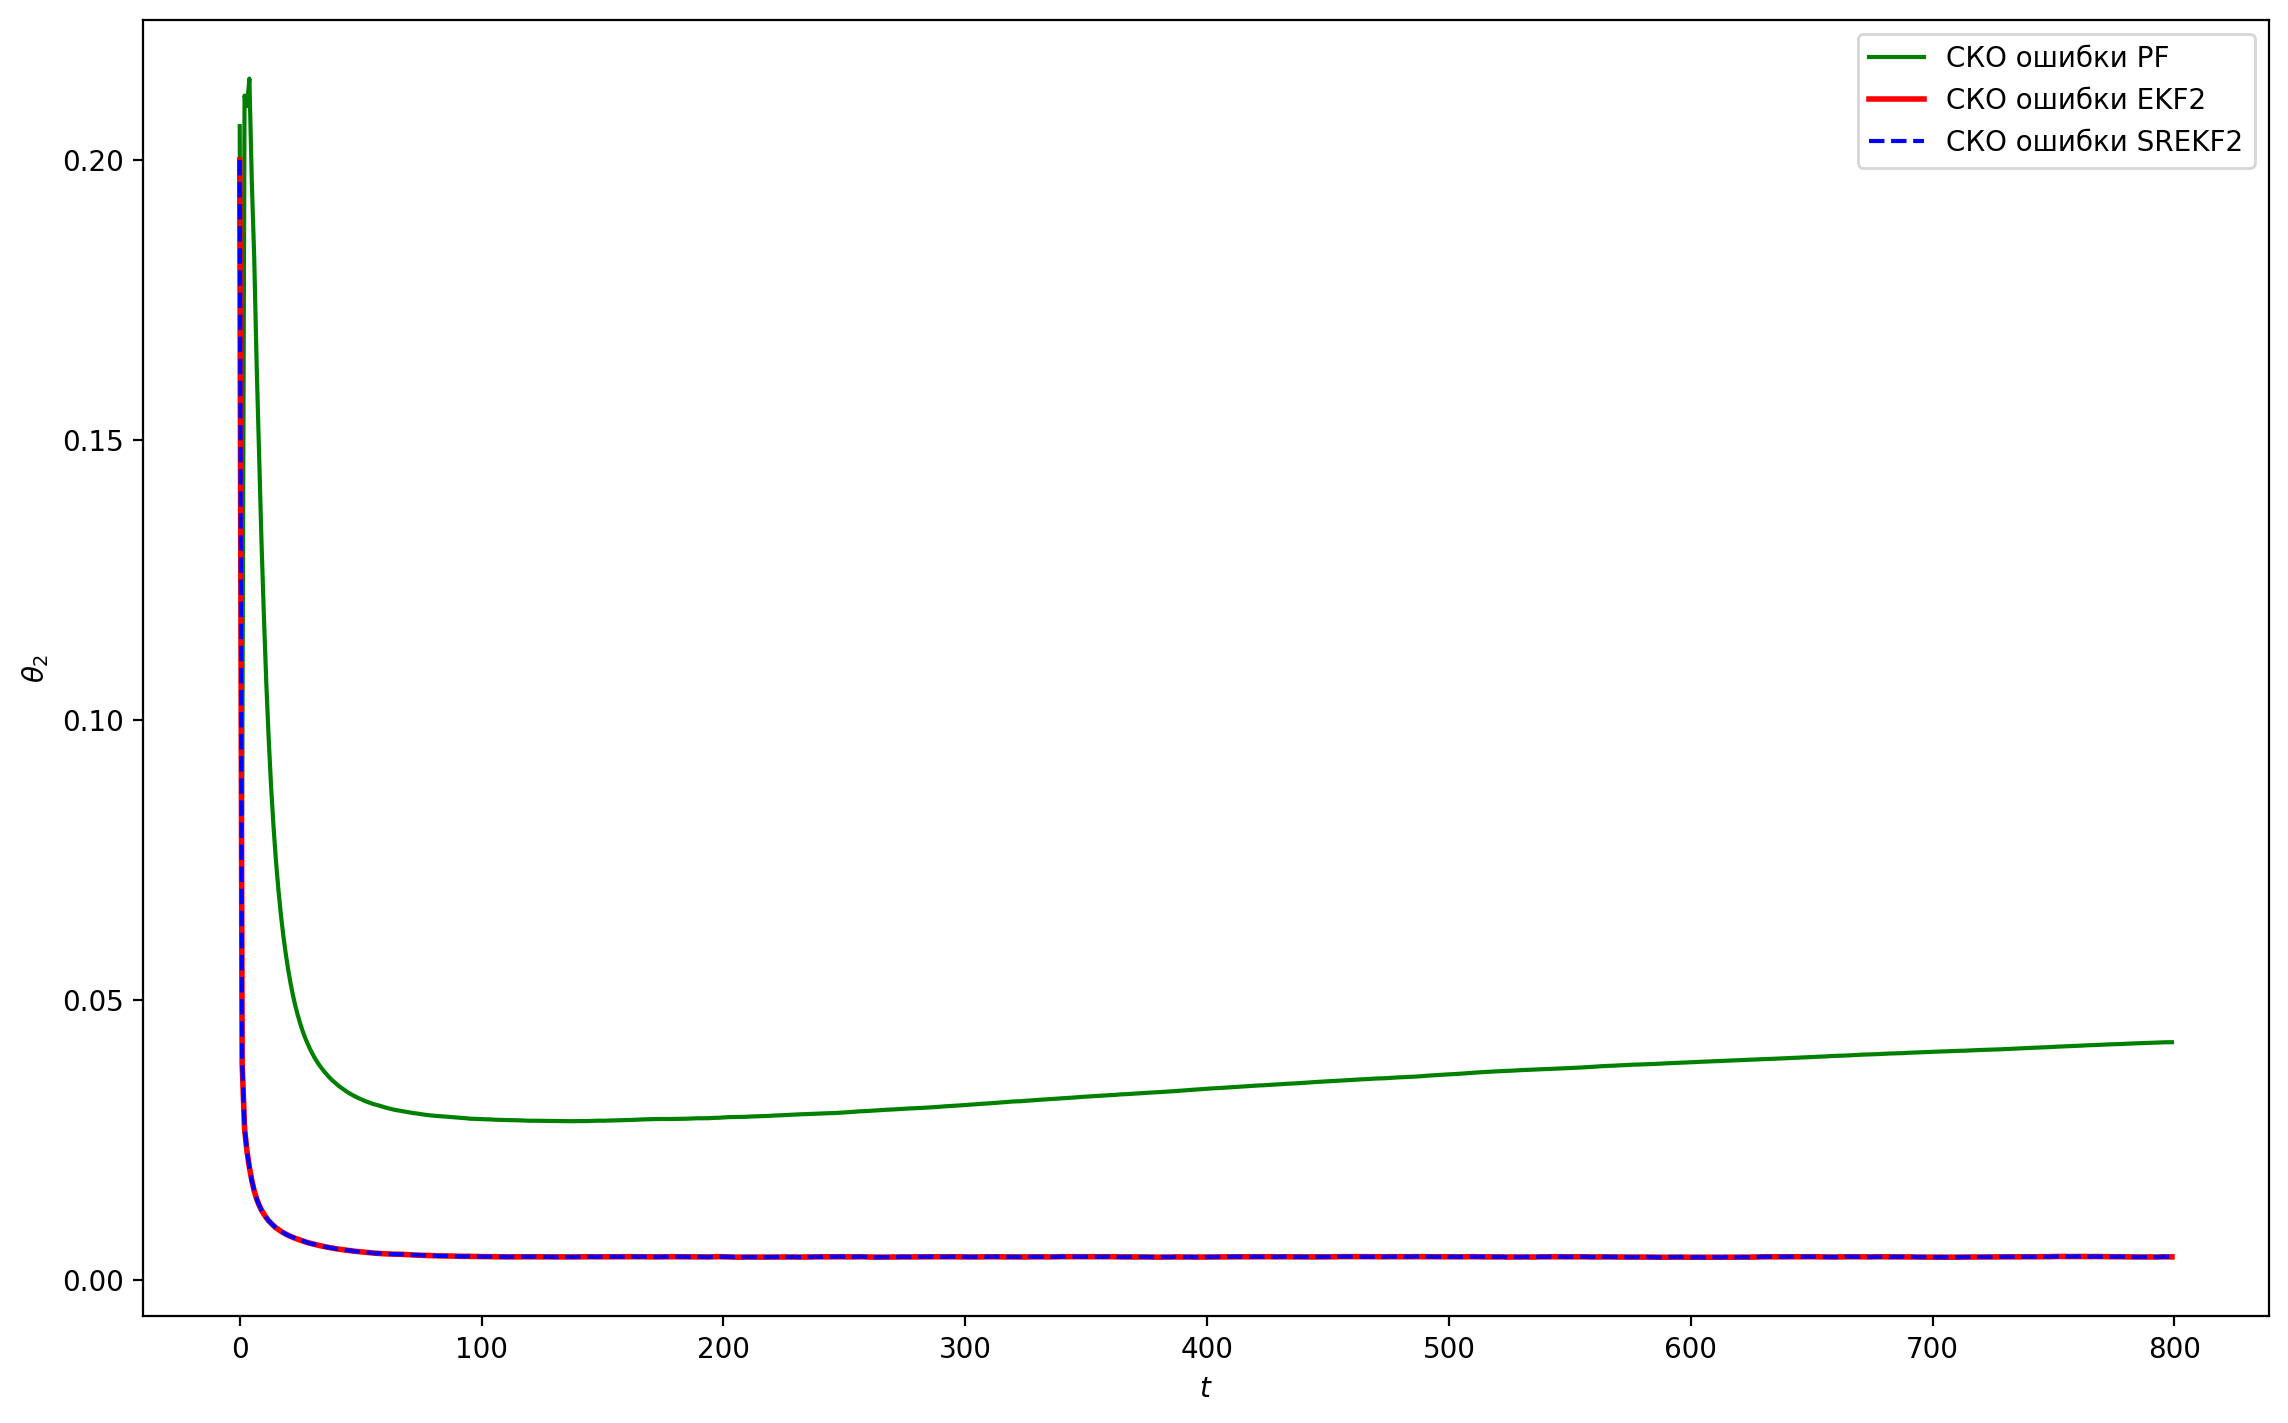

In [ ]:
fig, axs[i] = plt.subplots(figsize=(7 * (1 + np.sqrt(5)) / 2, 7), layout="constrained")

i = 3

a1 = np.sqrt(mse_pf[:, i] * (1e5 / (1e5 - 5758)))
a2 = np.sqrt(mse_ekf2[:, i] * (1e5 / (1e5 - 2)))
a3 = np.sqrt(mse_srekf2[:, i] * (1e5 / (1e5 - 2)))

axs[i].plot(np.arange(T), a1, label="СКО ошибки PF", color="green")

axs[i].plot(np.arange(T), a2, label="СКО ошибки EKF2", lw=2, color="red")

axs[i].plot(np.arange(T), a3, label="СКО ошибки SREKF2", ls="--", color="blue")

for a in [a1, a2, a3]:
    print(round(a[150], 5), "&", round(a[400], 5), "&", round(a[750], 5))

axs[i].set_xlabel("$t$")
axs[i].set_ylabel(names[i])
axs[i].legend()

plt.show()